In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

Using device: cpu
Epoch [1/10], Train Loss: 0.3490, Train Acc: 89.69%, Test Loss: 0.1102, Test Acc: 96.43%, Precision: 0.9655, Recall: 0.9643, F1-score: 0.9642
Epoch [2/10], Train Loss: 0.0801, Train Acc: 97.51%, Test Loss: 0.0535, Test Acc: 98.27%, Precision: 0.9829, Recall: 0.9827, F1-score: 0.9827
Epoch [3/10], Train Loss: 0.0551, Train Acc: 98.27%, Test Loss: 0.0530, Test Acc: 98.33%, Precision: 0.9835, Recall: 0.9833, F1-score: 0.9833
Epoch [4/10], Train Loss: 0.0443, Train Acc: 98.60%, Test Loss: 0.0395, Test Acc: 98.80%, Precision: 0.9881, Recall: 0.9880, F1-score: 0.9880
Epoch [5/10], Train Loss: 0.0355, Train Acc: 98.86%, Test Loss: 0.0408, Test Acc: 98.71%, Precision: 0.9873, Recall: 0.9871, F1-score: 0.9871
Epoch [6/10], Train Loss: 0.0310, Train Acc: 99.05%, Test Loss: 0.0311, Test Acc: 99.04%, Precision: 0.9904, Recall: 0.9904, F1-score: 0.9904
Epoch [7/10], Train Loss: 0.0249, Train Acc: 99.22%, Test Loss: 0.0304, Test Acc: 98.96%, Precision: 0.9896, Recall: 0.9896, F1-sc

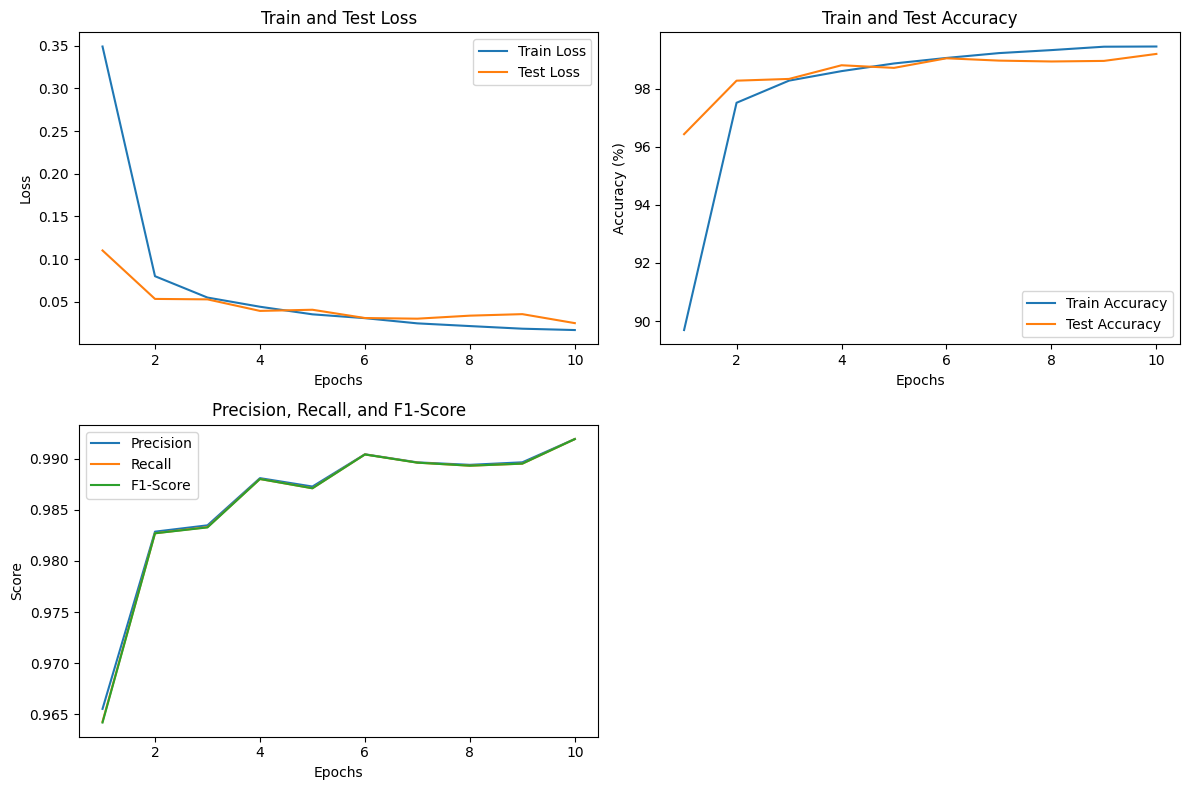

In [ ]:

# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the LeNet-5 model class
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(6, 16, 5, stride=1)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Load and preprocess the MNIST dataset
transform_mnist = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_mnist = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_mnist)
test_mnist = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_mnist)

train_loader_mnist = DataLoader(train_mnist, batch_size=128, shuffle=True)
test_loader_mnist = DataLoader(test_mnist, batch_size=128, shuffle=False)

# Instantiate the LeNet-5 model
lenet_model = LeNet5().to(device)

# Training function (as defined previously)
def train_model(model, train_loader, test_loader, num_epochs=10, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    precision_values = []
    recall_values = []
    f1_values = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        test_loss = 0.0
        correct_test = 0
        total_test = 0
        all_labels = []
        all_preds = []

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())

        test_loss /= len(test_loader)
        test_accuracy = 100 * correct_test / total_test
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        precision = precision_score(all_labels, all_preds, average='weighted')
        recall = recall_score(all_labels, all_preds, average='weighted')
        f1 = f1_score(all_labels, all_preds, average='weighted')

        precision_values.append(precision)
        recall_values.append(recall)
        f1_values.append(f1)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
              f"Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%, Precision: {precision:.4f}, "
              f"Recall: {recall:.4f}, F1-score: {f1:.4f}")

    # Return the training and evaluation metrics
    return {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'test_losses': test_losses,
        'test_accuracies': test_accuracies,
        'precision_values': precision_values,
        'recall_values': recall_values,
        'f1_values': f1_values
    }

#Function to plot metrics
def plot_metrics(metrics):
    epochs = range(1, len(metrics['train_losses']) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    plt.plot(epochs, metrics['train_losses'], label='Train Loss')
    plt.plot(epochs, metrics['test_losses'], label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train and Test Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(2, 2, 2)
    plt.plot(epochs, metrics['train_accuracies'], label='Train Accuracy')
    plt.plot(epochs, metrics['test_accuracies'], label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Train and Test Accuracy')
    plt.legend()

    # Plot Precision, Recall, F1-Score
    plt.subplot(2, 2, 3)
    plt.plot(epochs, metrics['precision_values'], label='Precision')
    plt.plot(epochs, metrics['recall_values'], label='Recall')
    plt.plot(epochs, metrics['f1_values'], label='F1-Score')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.title('Precision, Recall, and F1-Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Start training
metrics = train_model(lenet_model, train_loader_mnist, test_loader_mnist, num_epochs=10, learning_rate=0.001)

# Visualize the results
plot_metrics(metrics)

Using device: cpu
Epoch [1/10], Train Loss: 0.6489, Train Acc: 76.39%, Test Loss: 0.4619, Test Acc: 83.51%, Precision: 0.8407, Recall: 0.8351, F1-score: 0.8368
Epoch [2/10], Train Loss: 0.4074, Train Acc: 85.20%, Test Loss: 0.3921, Test Acc: 85.95%, Precision: 0.8648, Recall: 0.8595, F1-score: 0.8604
Epoch [3/10], Train Loss: 0.3535, Train Acc: 87.09%, Test Loss: 0.3627, Test Acc: 86.96%, Precision: 0.8742, Recall: 0.8696, F1-score: 0.8704
Epoch [4/10], Train Loss: 0.3209, Train Acc: 88.33%, Test Loss: 0.3416, Test Acc: 87.47%, Precision: 0.8738, Recall: 0.8747, F1-score: 0.8711
Epoch [5/10], Train Loss: 0.2989, Train Acc: 89.03%, Test Loss: 0.3147, Test Acc: 88.51%, Precision: 0.8888, Recall: 0.8851, F1-score: 0.8861
Epoch [6/10], Train Loss: 0.2776, Train Acc: 89.83%, Test Loss: 0.3157, Test Acc: 88.25%, Precision: 0.8845, Recall: 0.8825, F1-score: 0.8819
Epoch [7/10], Train Loss: 0.2650, Train Acc: 90.14%, Test Loss: 0.2997, Test Acc: 89.03%, Precision: 0.8893, Recall: 0.8903, F1-sc

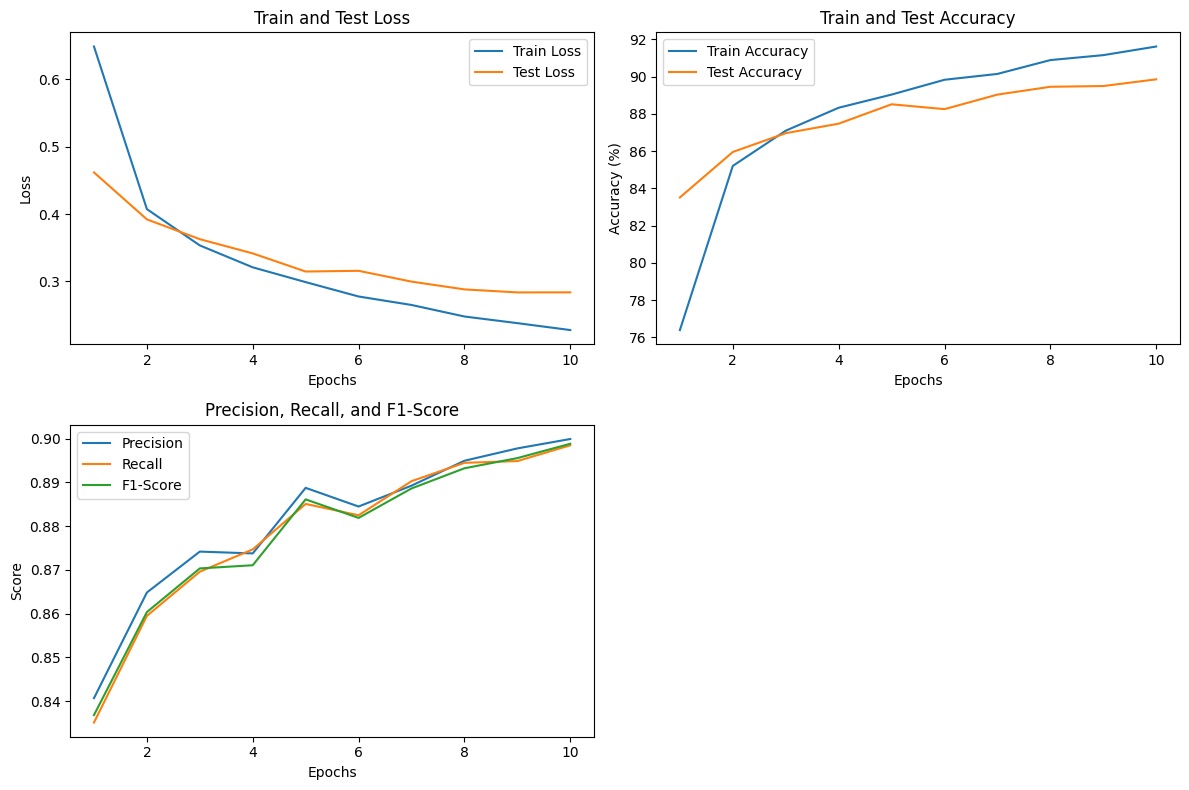

In [2]:

# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the LeNet-5 model class
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(6, 16, 5, stride=1)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Load and preprocess the fmnist dataset
transform_fmnist = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_fmnist = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_fmnist)
test_fmnist = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform_fmnist)

train_loader_fmnist = DataLoader(train_fmnist, batch_size=128, shuffle=True)
test_loader_fmnist = DataLoader(test_fmnist, batch_size=128, shuffle=False)

# Instantiate the LeNet-5 model
lenet_model = LeNet5().to(device)

# Training function (as defined previously)
def train_model(model, train_loader, test_loader, num_epochs=10, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    precision_values = []
    recall_values = []
    f1_values = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        test_loss = 0.0
        correct_test = 0
        total_test = 0
        all_labels = []
        all_preds = []

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())

        test_loss /= len(test_loader)
        test_accuracy = 100 * correct_test / total_test
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        precision = precision_score(all_labels, all_preds, average='weighted')
        recall = recall_score(all_labels, all_preds, average='weighted')
        f1 = f1_score(all_labels, all_preds, average='weighted')

        precision_values.append(precision)
        recall_values.append(recall)
        f1_values.append(f1)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
              f"Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%, Precision: {precision:.4f}, "
              f"Recall: {recall:.4f}, F1-score: {f1:.4f}")

    # Return the training and evaluation metrics
    return {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'test_losses': test_losses,
        'test_accuracies': test_accuracies,
        'precision_values': precision_values,
        'recall_values': recall_values,
        'f1_values': f1_values
    }

#Function to plot metrics
def plot_metrics(metrics):
    epochs = range(1, len(metrics['train_losses']) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    plt.plot(epochs, metrics['train_losses'], label='Train Loss')
    plt.plot(epochs, metrics['test_losses'], label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train and Test Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(2, 2, 2)
    plt.plot(epochs, metrics['train_accuracies'], label='Train Accuracy')
    plt.plot(epochs, metrics['test_accuracies'], label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Train and Test Accuracy')
    plt.legend()

    # Plot Precision, Recall, F1-Score
    plt.subplot(2, 2, 3)
    plt.plot(epochs, metrics['precision_values'], label='Precision')
    plt.plot(epochs, metrics['recall_values'], label='Recall')
    plt.plot(epochs, metrics['f1_values'], label='F1-Score')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.title('Precision, Recall, and F1-Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Start training
metrics = train_model(lenet_model, train_loader_fmnist, test_loader_fmnist, num_epochs=10, learning_rate=0.001)

# Visualize the results
plot_metrics(metrics)

Using device: cpu
Files already downloaded and verified
Files already downloaded and verified
Epoch [1/10], Train Loss: 1.6751, Train Acc: 38.88%, Test Loss: 1.4393, Test Acc: 47.40%, Precision: 0.4729, Recall: 0.4740, F1-score: 0.4660
Epoch [2/10], Train Loss: 1.3780, Train Acc: 50.19%, Test Loss: 1.2972, Test Acc: 53.33%, Precision: 0.5326, Recall: 0.5333, F1-score: 0.5259
Epoch [3/10], Train Loss: 1.2586, Train Acc: 54.74%, Test Loss: 1.2434, Test Acc: 55.02%, Precision: 0.5652, Recall: 0.5502, F1-score: 0.5365
Epoch [4/10], Train Loss: 1.1708, Train Acc: 58.15%, Test Loss: 1.1864, Test Acc: 57.34%, Precision: 0.5869, Recall: 0.5734, F1-score: 0.5712
Epoch [5/10], Train Loss: 1.0987, Train Acc: 61.02%, Test Loss: 1.1456, Test Acc: 59.52%, Precision: 0.5894, Recall: 0.5952, F1-score: 0.5871
Epoch [6/10], Train Loss: 1.0417, Train Acc: 62.80%, Test Loss: 1.0985, Test Acc: 61.27%, Precision: 0.6094, Recall: 0.6127, F1-score: 0.6097
Epoch [7/10], Train Loss: 1.0001, Train Acc: 64.64%, T

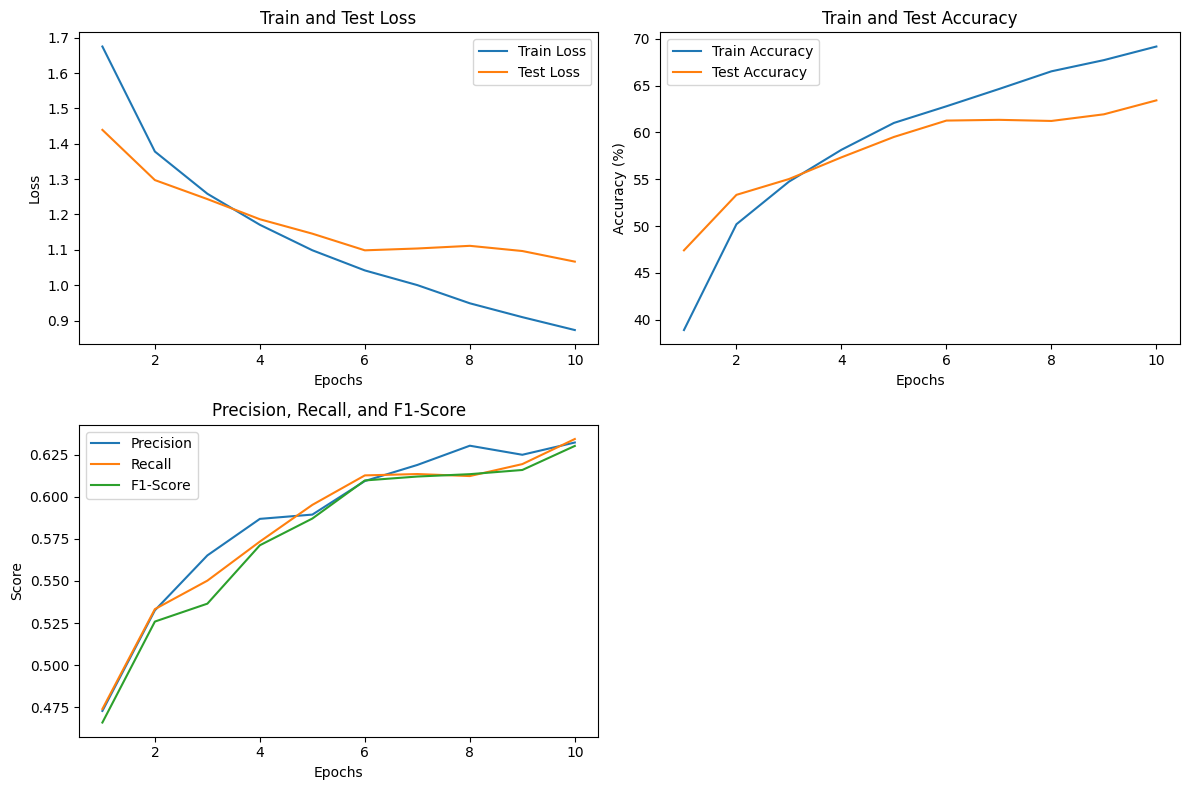

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the LeNet-5 model class
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5, stride=1, padding=2)  # Adjusted for 3 input channels
        self.conv2 = nn.Conv2d(6, 16, 5, stride=1)
        self.fc1 = nn.Linear(6 * 6 * 16, 120)  # Updated input size
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Load and preprocess the CIFAR-10 dataset
transform_cifar10 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Adjusted for RGB images
])

train_cifar10 = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_cifar10)
test_cifar10 = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_cifar10)

train_loader_cifar10 = DataLoader(train_cifar10, batch_size=128, shuffle=True)
test_loader_cifar10 = DataLoader(test_cifar10, batch_size=128, shuffle=False)

# Instantiate the LeNet-5 model
lenet_model = LeNet5().to(device)

# Training function
def train_model(model, train_loader, test_loader, num_epochs=10, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    precision_values = []
    recall_values = []
    f1_values = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        test_loss = 0.0
        correct_test = 0
        total_test = 0
        all_labels = []
        all_preds = []

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())

        test_loss /= len(test_loader)
        test_accuracy = 100 * correct_test / total_test
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        precision = precision_score(all_labels, all_preds, average='weighted')
        recall = recall_score(all_labels, all_preds, average='weighted')
        f1 = f1_score(all_labels, all_preds, average='weighted')

        precision_values.append(precision)
        recall_values.append(recall)
        f1_values.append(f1)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
              f"Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%, Precision: {precision:.4f}, "
              f"Recall: {recall:.4f}, F1-score: {f1:.4f}")

    # Return the training and evaluation metrics
    return {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'test_losses': test_losses,
        'test_accuracies': test_accuracies,
        'precision_values': precision_values,
        'recall_values': recall_values,
        'f1_values': f1_values
    }

# Function to plot metrics
def plot_metrics(metrics):
    epochs = range(1, len(metrics['train_losses']) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    plt.plot(epochs, metrics['train_losses'], label='Train Loss')
    plt.plot(epochs, metrics['test_losses'], label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train and Test Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(2, 2, 2)
    plt.plot(epochs, metrics['train_accuracies'], label='Train Accuracy')
    plt.plot(epochs, metrics['test_accuracies'], label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Train and Test Accuracy')
    plt.legend()

    # Plot Precision, Recall, F1-Score
    plt.subplot(2, 2, 3)
    plt.plot(epochs, metrics['precision_values'], label='Precision')
    plt.plot(epochs, metrics['recall_values'], label='Recall')
    plt.plot(epochs, metrics['f1_values'], label='F1-Score')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.title('Precision, Recall, and F1-Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Start training
metrics = train_model(lenet_model, train_loader_cifar10, test_loader_cifar10, num_epochs=10, learning_rate=0.001)

# Visualize the results
plot_metrics(metrics)


ALEXNET


Training and testing on MNIST dataset:
Epoch 1/3, Train Loss: 0.3157, Train Acc: 89.29%, Test Loss: 0.0567, Test Acc: 98.24%
Epoch 2/3, Train Loss: 0.0764, Train Acc: 97.74%, Test Loss: 0.0467, Test Acc: 98.67%
Epoch 3/3, Train Loss: 0.0597, Train Acc: 98.27%, Test Loss: 0.0345, Test Acc: 99.00%
Training Complete
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       980
           1       1.00      0.99      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.98      1.00      0.99       892
           6       0.99      0.99      0.99       958
           7       0.98      1.00      0.99      1028
           8       0.99      0.98      0.99       974
           9       0.99      0.97      0.98      1009

    accuracy                           0.99     10000
   macro av

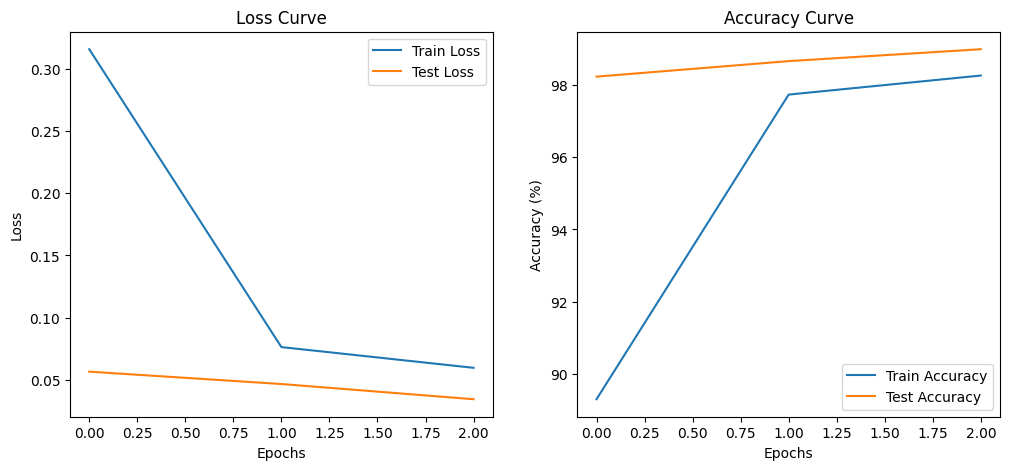


Training and testing on FMNIST dataset:
Epoch 1/3, Train Loss: 0.7604, Train Acc: 71.48%, Test Loss: 0.4028, Test Acc: 84.59%
Epoch 2/3, Train Loss: 0.3965, Train Acc: 85.33%, Test Loss: 0.3336, Test Acc: 87.62%
Epoch 3/3, Train Loss: 0.3431, Train Acc: 87.39%, Test Loss: 0.2995, Test Acc: 88.87%
Training Complete
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.79      0.82      1000
           1       0.98      0.98      0.98      1000
           2       0.83      0.85      0.84      1000
           3       0.92      0.87      0.90      1000
           4       0.80      0.84      0.82      1000
           5       0.96      0.98      0.97      1000
           6       0.66      0.70      0.68      1000
           7       0.96      0.94      0.95      1000
           8       0.98      0.97      0.98      1000
           9       0.96      0.96      0.96      1000

    accuracy                           0.89     10000
   macro a

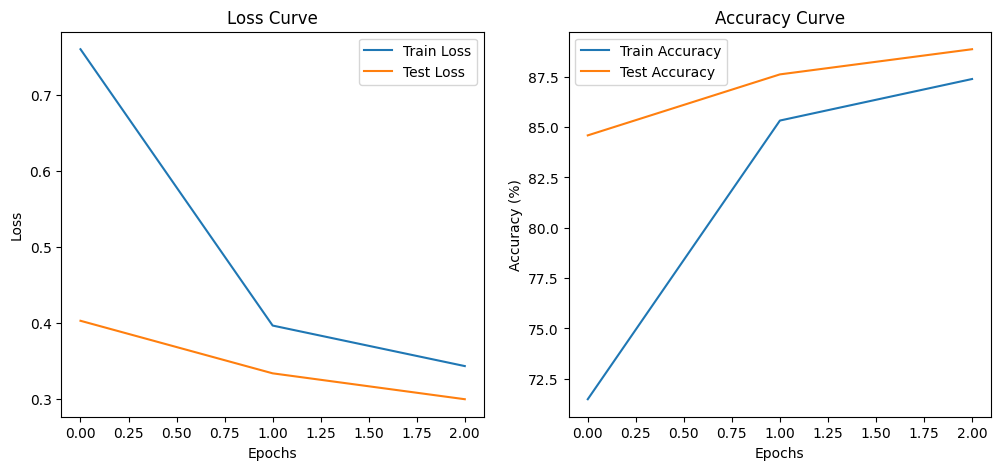


Training and testing on CIFAR10 dataset:
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/3, Train Loss: 1.7531, Train Acc: 35.08%, Test Loss: 1.4066, Test Acc: 48.52%
Epoch 2/3, Train Loss: 1.3264, Train Acc: 51.70%, Test Loss: 1.1291, Test Acc: 59.79%
Epoch 3/3, Train Loss: 1.1454, Train Acc: 59.15%, Test Loss: 1.0417, Test Acc: 63.47%
Training Complete
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.64      0.68      1000
           1       0.84      0.70      0.77      1000
           2       0.58      0.39      0.47      1000
           3       0.43      0.46      0.45      1000
           4       0.58      0.53      0.56      1000
           5       0.56      0.54      0.55      1000
           6       0.64      0.78      0.70      1000
           7       0.64      0.78      0.70      1000
           8       0.82      0.71      0.76      1000
           9       0.59      0.82      0.6

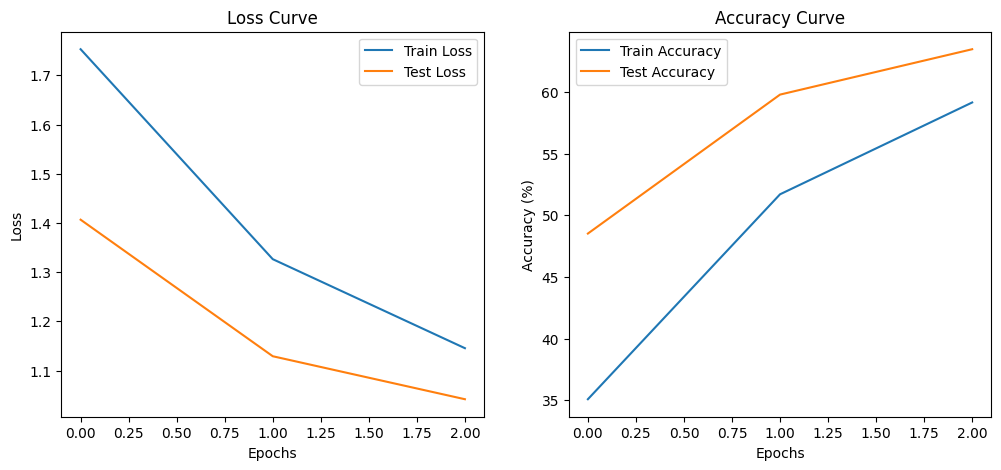

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# Data Loading Function
def load_data(dataset_name, batch_size=32):
    transform = transforms.Compose([
        transforms.Resize((227, 227)),  # AlexNet expects input size of 227x227
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  # Normalization
    ])

    if dataset_name == "MNIST":
        train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
        test_dataset = datasets.MNIST(root="./data", train=False, transform=transform, download=True)
    elif dataset_name == "FMNIST":
        train_dataset = datasets.FashionMNIST(root="./data", train=True, transform=transform, download=True)
        test_dataset = datasets.FashionMNIST(root="./data", train=False, transform=transform, download=True)
    elif dataset_name == "CIFAR10":
        transform = transforms.Compose([
            transforms.Resize((227, 227)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        train_dataset = datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)
        test_dataset = datasets.CIFAR10(root="./data", train=False, transform=transform, download=True)
    else:
        raise ValueError("Unsupported dataset")

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

# AlexNet Architecture
class AlexNet(nn.Module):
    def __init__(self, num_classes=10, in_channels=3):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Training and Evaluation Function
def train_model(model, train_loader, test_loader, epochs=5, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_loss_history = []
    train_acc_history = []
    test_loss_history = []
    test_acc_history = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)

        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        test_loss /= len(test_loader)
        test_acc = 100. * correct / total
        test_loss_history.append(test_loss)
        test_acc_history.append(test_acc)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

    print("Training Complete")

    # Evaluation Metrics
    print("Classification Report:")
    print(classification_report(all_labels, all_preds))

    print("Confusion Matrix:")
    print(confusion_matrix(all_labels, all_preds))

    # Plot Loss and Accuracy
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_loss_history, label="Train Loss")
    plt.plot(test_loss_history, label="Test Loss")
    plt.title("Loss Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_acc_history, label="Train Accuracy")
    plt.plot(test_acc_history, label="Test Accuracy")
    plt.title("Accuracy Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend()

    plt.show()

# Main Execution
def main():
    datasets_to_test = ["MNIST", "FMNIST", "CIFAR10"]
    for dataset_name in datasets_to_test:
        print(f"\nTraining and testing on {dataset_name} dataset:")

        # Adjust input channels based on dataset
        in_channels = 1 if dataset_name in ["MNIST", "FMNIST"] else 3

        # Load dataset
        train_loader, test_loader = load_data(dataset_name, batch_size=128)

        # Initialize AlexNet model
        model = AlexNet(num_classes=10, in_channels=in_channels)

        # Train and evaluate the model
        train_model(model, train_loader, test_loader, epochs=3, lr=0.001)

if __name__ == "__main__":
    main()


Googlenet


Training and testing on MNIST dataset:
Epoch 1/5, Train Loss: 701.8687, Train Acc: 46.57%, Test Loss: 12.5763, Test Acc: 95.22%
Epoch 2/5, Train Loss: 46.8829, Train Acc: 96.93%, Test Loss: 4.8972, Test Acc: 98.17%
Epoch 3/5, Train Loss: 29.3423, Train Acc: 98.14%, Test Loss: 3.2454, Test Acc: 98.77%
Epoch 4/5, Train Loss: 24.9144, Train Acc: 98.40%, Test Loss: 4.0902, Test Acc: 98.33%
Epoch 5/5, Train Loss: 20.8445, Train Acc: 98.67%, Test Loss: 7.3845, Test Acc: 97.02%

Training Complete

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       980
           1       1.00      0.98      0.99      1135
           2       0.99      0.94      0.96      1032
           3       0.93      1.00      0.96      1010
           4       0.99      0.98      0.98       982
           5       0.98      0.95      0.96       892
           6       1.00      0.93      0.96       958
           7       1.00      0.98      0.99    

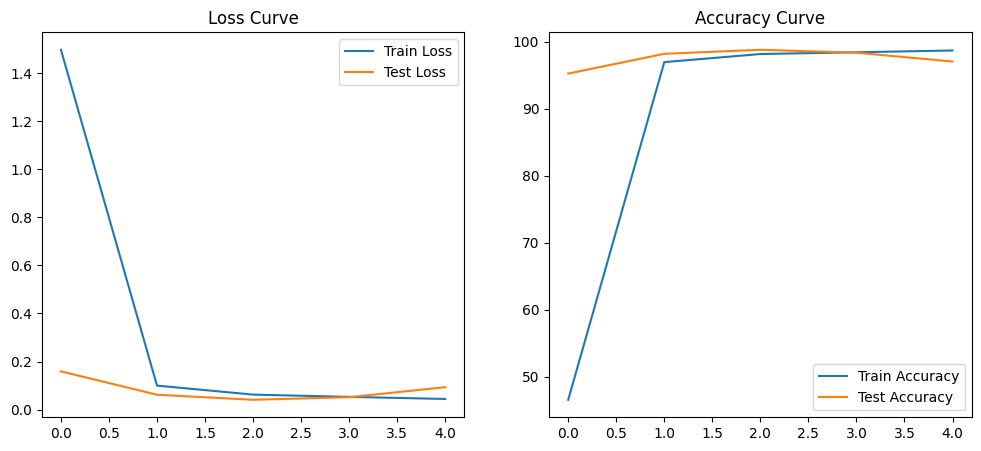


Training and testing on FMNIST dataset:
Epoch 1/5, Train Loss: 373.5984, Train Acc: 69.37%, Test Loss: 32.0043, Test Acc: 85.31%
Epoch 2/5, Train Loss: 164.1905, Train Acc: 87.48%, Test Loss: 27.0825, Test Acc: 87.76%
Epoch 3/5, Train Loss: 140.1342, Train Acc: 89.28%, Test Loss: 24.0279, Test Acc: 88.68%
Epoch 4/5, Train Loss: 4444346575.3646, Train Acc: 49.70%, Test Loss: 521233.3037, Test Acc: 10.00%
Epoch 5/5, Train Loss: 3090982.6395, Train Acc: 9.96%, Test Loss: 431368.4663, Test Acc: 10.00%

Training Complete

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1000
           1       0.00      0.00      0.00      1000
           2       0.00      0.00      0.00      1000
           3       0.10      1.00      0.18      1000
           4       0.00      0.00      0.00      1000
           5       0.00      0.00      0.00      1000
           6       0.00      0.00      0.00      1000
           7       0

C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:153

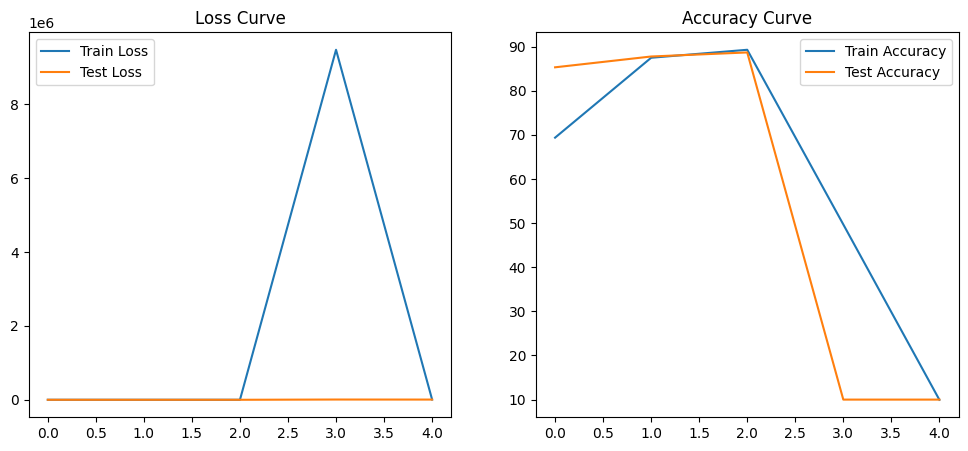


Training and testing on CIFAR10 dataset:
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/5, Train Loss: 814.2839, Train Acc: 19.32%, Test Loss: 137.3817, Test Acc: 31.69%
Epoch 2/5, Train Loss: 606.3654, Train Acc: 41.07%, Test Loss: 118.6519, Test Acc: 45.30%
Epoch 3/5, Train Loss: 482.3465, Train Acc: 55.27%, Test Loss: 93.2585, Test Acc: 55.97%
Epoch 4/5, Train Loss: 402.0763, Train Acc: 63.21%, Test Loss: 72.5934, Test Acc: 68.03%
Epoch 5/5, Train Loss: 341.5818, Train Acc: 69.45%, Test Loss: 67.0096, Test Acc: 70.80%

Training Complete

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.80      0.74      1000
           1       0.86      0.82      0.84      1000
           2       0.66      0.52      0.58      1000
           3       0.47      0.61      0.53      1000
           4       0.68      0.67      0.67      1000
           5       0.73      0.47      0.57      1000
           6 

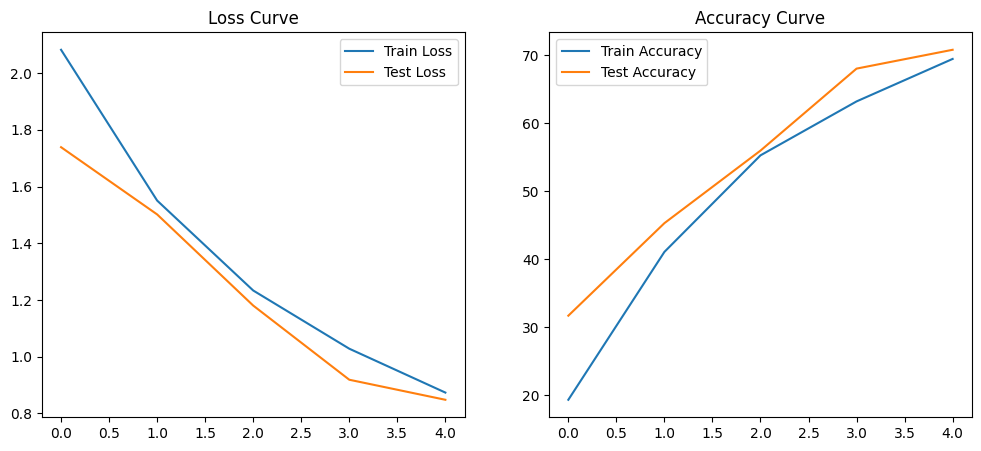

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# 1. Data Loading Function
def load_data(dataset_name, batch_size=64):
    transform_gray = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  # Normalization for grayscale
    ])
    
    transform_rgb = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalization for RGB
    ])

    if dataset_name == "MNIST":
        train_dataset = datasets.MNIST(root="./data", train=True, transform=transform_gray, download=True)
        test_dataset = datasets.MNIST(root="./data", train=False, transform=transform_gray, download=True)
    elif dataset_name == "FMNIST":
        train_dataset = datasets.FashionMNIST(root="./data", train=True, transform=transform_gray, download=True)
        test_dataset = datasets.FashionMNIST(root="./data", train=False, transform=transform_gray, download=True)
    elif dataset_name == "CIFAR10":
        train_dataset = datasets.CIFAR10(root="./data", train=True, transform=transform_rgb, download=True)
        test_dataset = datasets.CIFAR10(root="./data", train=False, transform=transform_rgb, download=True)
    else:
        raise ValueError("Unsupported dataset name!")

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

# 2. Inception Block
class Inception(nn.Module):
    def __init__(self, in_channels, ch1x1, ch3x3red, ch3x3, ch5x5red, ch5x5, pool_proj):
        super(Inception, self).__init__()
        self.branch1 = nn.Conv2d(in_channels, ch1x1, kernel_size=1)

        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, ch3x3red, kernel_size=1),
            nn.Conv2d(ch3x3red, ch3x3, kernel_size=3, padding=1)
        )

        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, ch5x5red, kernel_size=1),
            nn.Conv2d(ch5x5red, ch5x5, kernel_size=5, padding=2)
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, pool_proj, kernel_size=1)
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)
        outputs = [branch1, branch2, branch3, branch4]
        return torch.cat(outputs, 1)

# 3. GoogLeNet Architecture
class GoogLeNet(nn.Module):
    def __init__(self, num_classes=10, in_channels=3):
        super(GoogLeNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception3a = Inception(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = Inception(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception4a = Inception(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = Inception(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = Inception(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = Inception(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = Inception(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception5a = Inception(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = Inception(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool1(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool2(x)

        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)

        x = self.inception4a(x)
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        x = self.inception4e(x)
        x = self.maxpool4(x)

        x = self.inception5a(x)
        x = self.inception5b(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

# 4. Training Function
def train_model(model, train_loader, test_loader, epochs=5, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_loss_history, train_acc_history = [], []
    test_loss_history, test_acc_history = [], []

    for epoch in range(epochs):
        model.train()
        train_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_acc = 100. * correct / total
        train_loss_history.append(train_loss / len(train_loader))
        train_acc_history.append(train_acc)

        # Evaluation
        model.eval()
        test_loss, correct, total = 0.0, 0, 0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()

                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        test_acc = 100. * correct / total
        test_loss_history.append(test_loss / len(test_loader))
        test_acc_history.append(test_acc)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

    print("\nTraining Complete")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds))
    print("\nConfusion Matrix:")
    print(confusion_matrix(all_labels, all_preds))

    # Plot Loss and Accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_history, label="Train Loss")
    plt.plot(test_loss_history, label="Test Loss")
    plt.title("Loss Curve")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_acc_history, label="Train Accuracy")
    plt.plot(test_acc_history, label="Test Accuracy")
    plt.title("Accuracy Curve")
    plt.legend()

    plt.show()

# 5. Main Execution
def main():
    datasets_to_test = ["MNIST", "FMNIST", "CIFAR10"]
    for dataset_name in datasets_to_test:
        print(f"\nTraining and testing on {dataset_name} dataset:")
        in_channels = 1 if dataset_name in ["MNIST", "FMNIST"] else 3
        train_loader, test_loader = load_data(dataset_name, batch_size=128)
        model = GoogLeNet(num_classes=10, in_channels=in_channels)
        train_model(model, train_loader, test_loader, epochs=5, lr=0.001)

if __name__ == "__main__":
    main()


VGGNet

Files already downloaded and verified
Files already downloaded and verified
Epoch 1/5, Train Loss: 1.6744, Train Acc: 36.94%, Test Loss: 1.3152, Test Acc: 51.48%
Epoch 2/5, Train Loss: 1.2083, Train Acc: 56.45%, Test Loss: 1.0505, Test Acc: 62.68%
Epoch 3/5, Train Loss: 0.9548, Train Acc: 66.38%, Test Loss: 0.8551, Test Acc: 70.38%
Epoch 4/5, Train Loss: 0.7834, Train Acc: 72.83%, Test Loss: 0.7995, Test Acc: 72.26%
Epoch 5/5, Train Loss: 0.6592, Train Acc: 77.23%, Test Loss: 0.7433, Test Acc: 74.81%
Training Complete
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.85      0.78      1000
           1       0.79      0.92      0.85      1000
           2       0.73      0.53      0.62      1000
           3       0.63      0.53      0.58      1000
           4       0.65      0.75      0.69      1000
           5       0.67      0.70      0.68      1000
           6       0.71      0.86      0.78      1000
           7       0

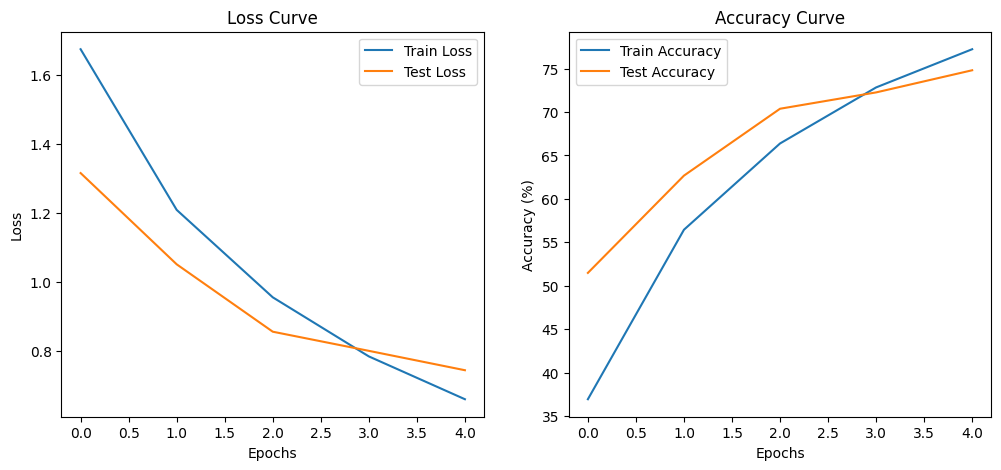

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# 1. Preprocessing and Data Loading
def load_data(dataset_name, batch_size=64):
    transform = transforms.Compose([
        transforms.Resize((64, 64)),  # Reduce input size to speed up computation
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  # Normalization
    ])

    if dataset_name == "MNIST":
        train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
        test_dataset = datasets.MNIST(root="./data", train=False, transform=transform, download=True)
    elif dataset_name == "FMNIST":
        train_dataset = datasets.FashionMNIST(root="./data", train=True, transform=transform, download=True)
        test_dataset = datasets.FashionMNIST(root="./data", train=False, transform=transform, download=True)
    elif dataset_name == "CIFAR10":
        transform = transforms.Compose([
            transforms.Resize((64, 64)),  # Reduce input size
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        train_dataset = datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)
        test_dataset = datasets.CIFAR10(root="./data", train=False, transform=transform, download=True)
    else:
        raise ValueError("Unsupported dataset")

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

# 2. Define VGG Architecture
class VGGNet(nn.Module):
    def __init__(self, num_classes=10):
        super(VGGNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 4 * 4, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1024, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# 3. Training Function
def train_model(model, train_loader, test_loader, epochs=5, lr=0.001):  # Reduced epochs for faster execution
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_loss_history = []
    train_acc_history = []
    test_loss_history = []
    test_acc_history = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)

        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        test_loss /= len(test_loader)
        test_acc = 100. * correct / total
        test_loss_history.append(test_loss)
        test_acc_history.append(test_acc)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

    print("Training Complete")

    # Evaluation Metrics
    print("Classification Report:")
    print(classification_report(all_labels, all_preds))

    print("Confusion Matrix:")
    print(confusion_matrix(all_labels, all_preds))

    # Plot Loss and Accuracy
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_loss_history, label="Train Loss")
    plt.plot(test_loss_history, label="Test Loss")
    plt.title("Loss Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_acc_history, label="Train Accuracy")
    plt.plot(test_acc_history, label="Test Accuracy")
    plt.title("Accuracy Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend()

    plt.show()

# 4. Main Execution
def main():
    train_loader, test_loader = load_data("CIFAR10", batch_size=128)  # Larger batch size for faster computation
    model = VGGNet(num_classes=10)
    train_model(model, train_loader, test_loader, epochs=5, lr=0.001)

if __name__ == "__main__":
    main()


Training and testing on MNIST dataset:
Epoch 1/5, Train Loss: 0.5459, Train Acc: 80.71%, Test Loss: 0.0545, Test Acc: 98.20%
Epoch 2/5, Train Loss: 0.0626, Train Acc: 98.16%, Test Loss: 0.0382, Test Acc: 98.73%
Epoch 3/5, Train Loss: 0.0452, Train Acc: 98.75%, Test Loss: 0.0327, Test Acc: 98.89%
Epoch 4/5, Train Loss: 0.0359, Train Acc: 98.98%, Test Loss: 0.0297, Test Acc: 99.08%
Epoch 5/5, Train Loss: 0.0298, Train Acc: 99.15%, Test Loss: 0.0365, Test Acc: 98.98%
Training Complete
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.99      1.00      0.99      1032
           3       0.98      1.00      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.97      0.99      0.98       892
           6       1.00      0.98      0.99       958
           7       1.00      0.99      0.99      1028
  

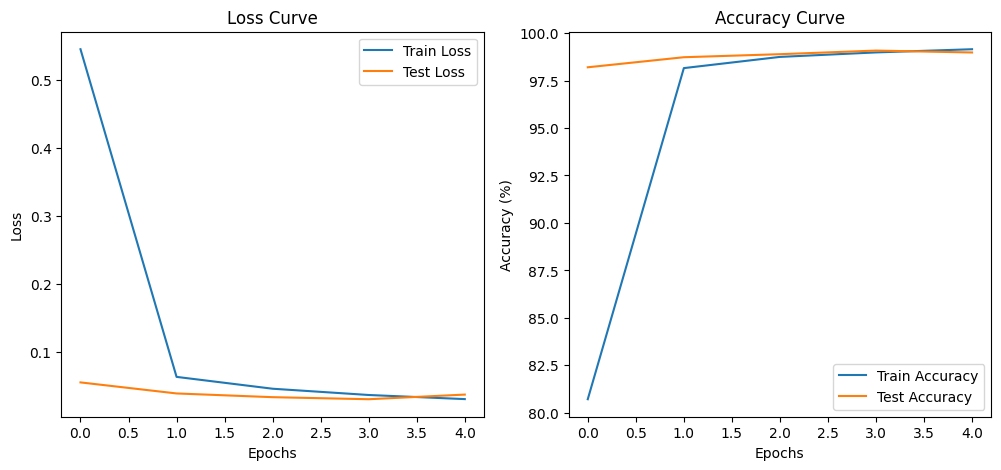


Training and testing on FMNIST dataset:
Epoch 1/5, Train Loss: 0.6184, Train Acc: 76.87%, Test Loss: 0.3657, Test Acc: 86.29%
Epoch 2/5, Train Loss: 0.3061, Train Acc: 88.81%, Test Loss: 0.2932, Test Acc: 89.24%
Epoch 3/5, Train Loss: 0.2522, Train Acc: 90.74%, Test Loss: 0.2781, Test Acc: 90.12%
Epoch 4/5, Train Loss: 0.2172, Train Acc: 92.06%, Test Loss: 0.2366, Test Acc: 91.47%
Epoch 5/5, Train Loss: 0.1934, Train Acc: 92.96%, Test Loss: 0.2321, Test Acc: 91.49%
Training Complete
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1000
           1       0.99      0.98      0.99      1000
           2       0.83      0.90      0.87      1000
           3       0.90      0.95      0.92      1000
           4       0.90      0.81      0.85      1000
           5       0.98      0.99      0.99      1000
           6       0.79      0.70      0.74      1000
           7       0.95      0.98      0.96      1000
 

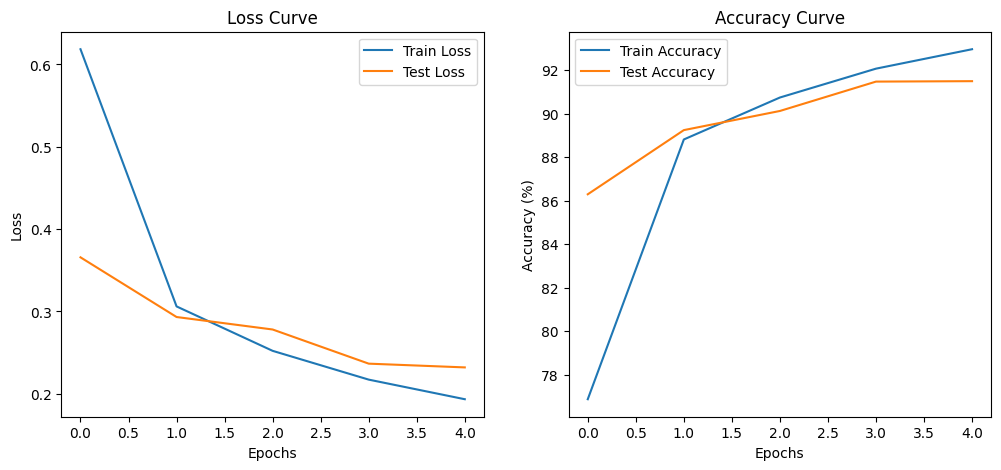

In [3]:
# 1. Preprocessing and Data Loading
def load_data(dataset_name, batch_size=64):
    if dataset_name in ["MNIST", "FMNIST"]:
        transform = transforms.Compose([
            transforms.Resize((64, 64)),  # Resize for VGGNet compatibility
            transforms.Grayscale(3),  # Convert 1-channel to 3-channel
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])
    else:
        raise ValueError("Unsupported dataset")

    if dataset_name == "MNIST":
        train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
        test_dataset = datasets.MNIST(root="./data", train=False, transform=transform, download=True)
    elif dataset_name == "FMNIST":
        train_dataset = datasets.FashionMNIST(root="./data", train=True, transform=transform, download=True)
        test_dataset = datasets.FashionMNIST(root="./data", train=False, transform=transform, download=True)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

# 2. Adjusted VGGNet
class VGGNet(nn.Module):
    def __init__(self, num_classes=10, input_channels=3):
        super(VGGNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 4 * 4, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1024, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# 3. Training Function (No Changes Needed)

# 4. Main Execution
def main():
    datasets_to_test = ["MNIST", "FMNIST"]
    for dataset_name in datasets_to_test:
        print(f"\nTraining and testing on {dataset_name} dataset:")
        train_loader, test_loader = load_data(dataset_name, batch_size=128)
        input_channels = 3  # Since we convert grayscale to RGB
        model = VGGNet(num_classes=10, input_channels=input_channels)
        train_model(model, train_loader, test_loader, epochs=5, lr=0.001)

if __name__ == "__main__":
    main()


ResNet

Training and testing on MNIST dataset:
Epoch 1/5, Train Loss: 0.1031, Train Acc: 96.76%, Test Loss: 0.0394, Test Acc: 98.92%
Epoch 2/5, Train Loss: 0.0442, Train Acc: 98.64%, Test Loss: 0.0246, Test Acc: 99.24%
Epoch 3/5, Train Loss: 0.0309, Train Acc: 99.02%, Test Loss: 0.0269, Test Acc: 99.13%
Epoch 4/5, Train Loss: 0.0255, Train Acc: 99.19%, Test Loss: 0.0270, Test Acc: 99.14%
Epoch 5/5, Train Loss: 0.0236, Train Acc: 99.26%, Test Loss: 0.0267, Test Acc: 99.16%
Training Complete
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       1.00      1.00      1.00      1135
           2       0.99      1.00      0.99      1032
           3       0.99      0.99      0.99      1010
           4       1.00      0.99      0.99       982
           5       0.99      0.98      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
   

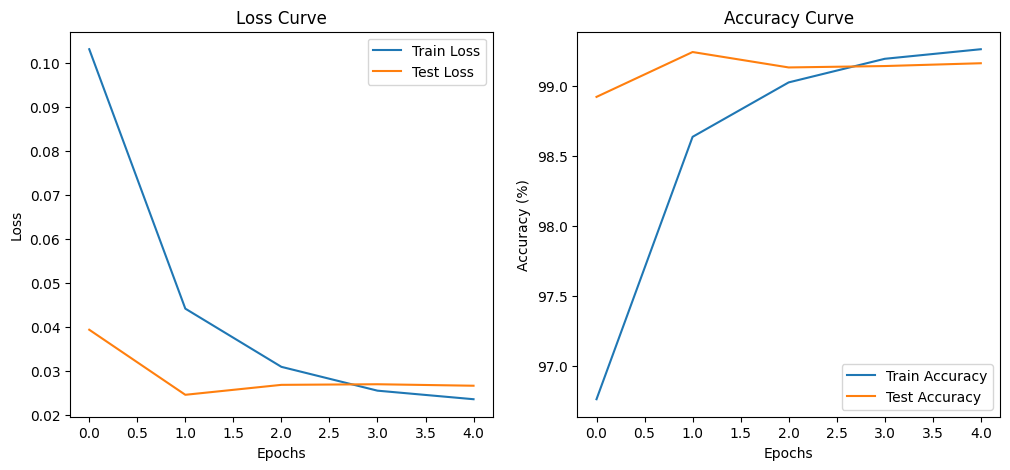

Training and testing on FMNIST dataset:
Epoch 1/5, Train Loss: 0.3697, Train Acc: 86.56%, Test Loss: 0.2926, Test Acc: 89.08%
Epoch 2/5, Train Loss: 0.2470, Train Acc: 90.82%, Test Loss: 0.2630, Test Acc: 90.25%
Epoch 3/5, Train Loss: 0.2079, Train Acc: 92.31%, Test Loss: 0.2293, Test Acc: 91.63%
Epoch 4/5, Train Loss: 0.1811, Train Acc: 93.34%, Test Loss: 0.2405, Test Acc: 91.50%
Epoch 5/5, Train Loss: 0.1615, Train Acc: 94.02%, Test Loss: 0.2160, Test Acc: 92.24%
Training Complete
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1000
           1       0.99      0.99      0.99      1000
           2       0.86      0.90      0.88      1000
           3       0.93      0.93      0.93      1000
           4       0.87      0.89      0.88      1000
           5       0.98      0.98      0.98      1000
           6       0.83      0.71      0.77      1000
           7       0.95      0.98      0.96      1000
  

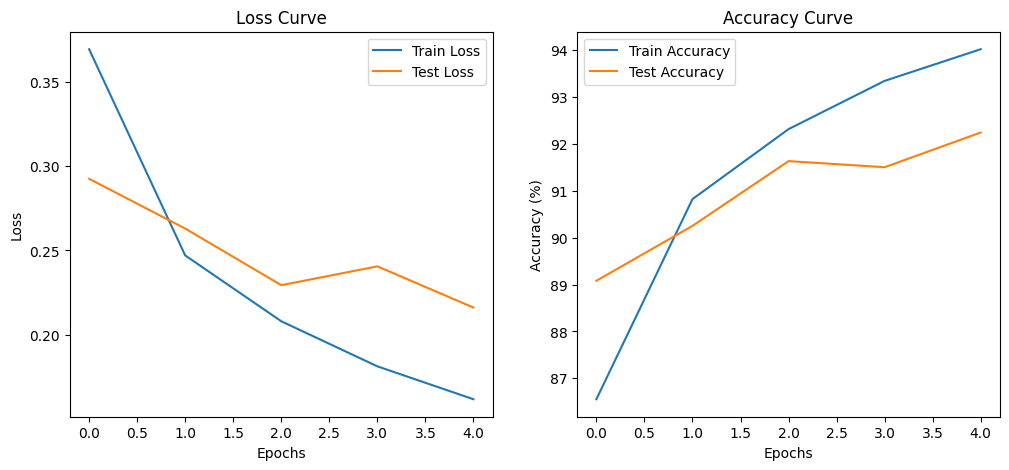

Training and testing on CIFAR10 dataset:
Files already downloaded and verified
Files already downloaded and verified


RuntimeError: Given groups=1, weight of size [64, 1, 7, 7], expected input[128, 3, 64, 64] to have 1 channels, but got 3 channels instead

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# 1. Preprocessing and Data Loading
def load_data(dataset_name, batch_size=64):
    transform = transforms.Compose([
        transforms.Resize((64, 64)),  # Reduce input size to speed up computation
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  # Normalization
    ])

    if dataset_name == "MNIST":
        train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
        test_dataset = datasets.MNIST(root="./data", train=False, transform=transform, download=True)
    elif dataset_name == "FMNIST":
        train_dataset = datasets.FashionMNIST(root="./data", train=True, transform=transform, download=True)
        test_dataset = datasets.FashionMNIST(root="./data", train=False, transform=transform, download=True)
    elif dataset_name == "CIFAR10":
        transform = transforms.Compose([
            transforms.Resize((64, 64)),  # Reduce input size
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        train_dataset = datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)
        test_dataset = datasets.CIFAR10(root="./data", train=False, transform=transform, download=True)
    else:
        raise ValueError("Unsupported dataset")

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader


# 2. Define ResNet Architecture
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10, in_channels=3):  # Added in_channels parameter
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)  # Use in_channels
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)


    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


# 3. Training Function
def train_model(model, train_loader, test_loader, epochs=5, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_loss_history = []
    train_acc_history = []
    test_loss_history = []
    test_acc_history = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)

        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        test_loss /= len(test_loader)
        test_acc = 100. * correct / total
        test_loss_history.append(test_loss)
        test_acc_history.append(test_acc)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

    print("Training Complete")

    # Evaluation Metrics
    print("Classification Report:")
    print(classification_report(all_labels, all_preds))

    print("Confusion Matrix:")
    print(confusion_matrix(all_labels, all_preds))

    # Plot Loss and Accuracy
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_loss_history, label="Train Loss")
    plt.plot(test_loss_history, label="Test Loss")
    plt.title("Loss Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_acc_history, label="Train Accuracy")
    plt.plot(test_acc_history, label="Test Accuracy")
    plt.title("Accuracy Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend()

    plt.show()


# 4. Main Execution
def main():
    datasets_to_test = ["MNIST", "FMNIST", "CIFAR10"]
    for dataset_name in datasets_to_test:
        print(f"Training and testing on {dataset_name} dataset:")
        train_loader, test_loader = load_data(dataset_name, batch_size=128)
        model = ResNet(ResidualBlock, [2, 2, 2, 2], num_classes=10, in_channels=1)
        train_model(model, train_loader, test_loader, epochs=5, lr=0.001)


if __name__ == "__main__":
    main()


Training and testing on CIFAR10 dataset:
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/5, Train Loss: 1.2687, Train Acc: 54.11%, Test Loss: 1.1125, Test Acc: 61.10%
Epoch 2/5, Train Loss: 0.8277, Train Acc: 70.76%, Test Loss: 0.9077, Test Acc: 67.96%
Epoch 3/5, Train Loss: 0.6275, Train Acc: 77.95%, Test Loss: 0.7364, Test Acc: 75.23%
Epoch 4/5, Train Loss: 0.5009, Train Acc: 82.54%, Test Loss: 0.6688, Test Acc: 76.92%
Epoch 5/5, Train Loss: 0.3879, Train Acc: 86.51%, Test Loss: 0.6793, Test Acc: 77.61%
Training Complete
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.89      0.79      1000
           1       0.94      0.81      0.87      1000
           2       0.81      0.56      0.66      1000
           3       0.59      0.68      0.63      1000
           4       0.75      0.76      0.76      1000
           5       0.79      0.58      0.67      1000
           6       0.76      0.88

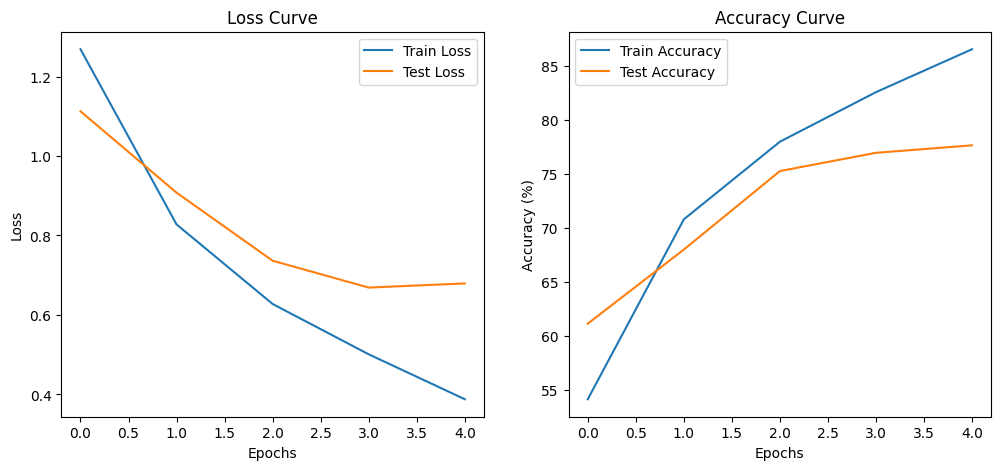

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# 1. Preprocessing and Data Loading
def load_data(dataset_name, batch_size=64):
    transform = transforms.Compose([
        transforms.Resize((64, 64)),  # Reduce input size to speed up computation
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  # Normalization
    ])

    
    if dataset_name == "CIFAR10":
        transform = transforms.Compose([
            transforms.Resize((64, 64)),  # Reduce input size
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        train_dataset = datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)
        test_dataset = datasets.CIFAR10(root="./data", train=False, transform=transform, download=True)
    else:
        raise ValueError("Unsupported dataset")

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader


# 2. Define ResNet Architecture
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


# 3. Training Function
def train_model(model, train_loader, test_loader, epochs=5, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_loss_history = []
    train_acc_history = []
    test_loss_history = []
    test_acc_history = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)

        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        test_loss /= len(test_loader)
        test_acc = 100. * correct / total
        test_loss_history.append(test_loss)
        test_acc_history.append(test_acc)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

    print("Training Complete")

    # Evaluation Metrics
    print("Classification Report:")
    print(classification_report(all_labels, all_preds))

    print("Confusion Matrix:")
    print(confusion_matrix(all_labels, all_preds))

    # Plot Loss and Accuracy
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_loss_history, label="Train Loss")
    plt.plot(test_loss_history, label="Test Loss")
    plt.title("Loss Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_acc_history, label="Train Accuracy")
    plt.plot(test_acc_history, label="Test Accuracy")
    plt.title("Accuracy Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend()

    plt.show()


# 4. Main Execution
def main():
    datasets_to_test = ["CIFAR10"]
    for dataset_name in datasets_to_test:
        print(f"Training and testing on {dataset_name} dataset:")
        train_loader, test_loader = load_data(dataset_name, batch_size=128)
        model = ResNet(ResidualBlock, [2, 2, 2, 2], num_classes=10)
        train_model(model, train_loader, test_loader, epochs=5, lr=0.001)


if __name__ == "__main__":
    main()


Xception

Training and testing on MNIST dataset:
Epoch 1/3, Train Loss: 0.5524, Train Acc: 81.28%, Test Loss: 0.1170, Test Acc: 96.51%
Epoch 2/3, Train Loss: 0.1059, Train Acc: 96.82%, Test Loss: 0.0724, Test Acc: 97.68%
Epoch 3/3, Train Loss: 0.0690, Train Acc: 97.88%, Test Loss: 0.0427, Test Acc: 98.68%
Training Complete
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       980
           1       1.00      0.99      0.99      1135
           2       0.99      0.98      0.99      1032
           3       0.99      1.00      0.99      1010
           4       0.99      0.99      0.99       982
           5       1.00      0.98      0.99       892
           6       0.99      0.98      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.96      0.99      0.97       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg

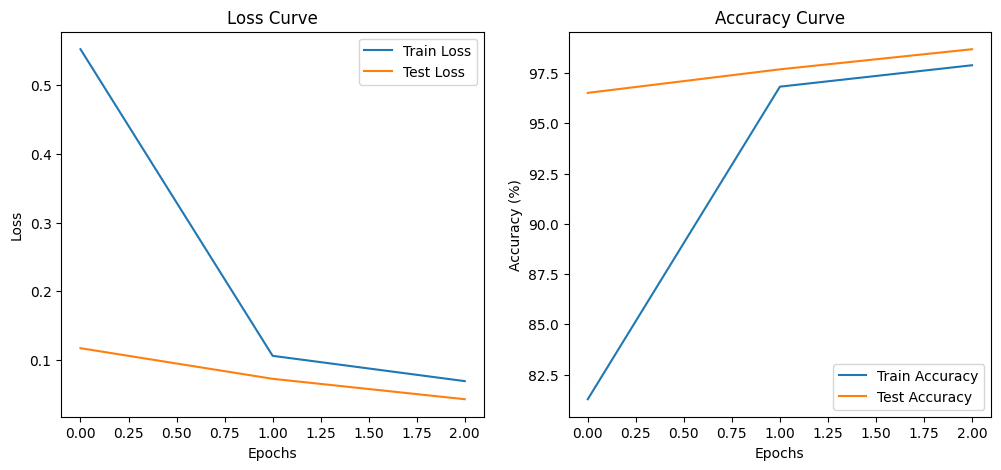

Training and testing on FMNIST dataset:
Epoch 1/3, Train Loss: 0.7973, Train Acc: 70.61%, Test Loss: 0.5289, Test Acc: 80.82%
Epoch 2/3, Train Loss: 0.4409, Train Acc: 83.91%, Test Loss: 0.4517, Test Acc: 84.00%
Epoch 3/3, Train Loss: 0.3577, Train Acc: 87.09%, Test Loss: 0.3480, Test Acc: 87.44%
Training Complete
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.88      0.82      1000
           1       0.99      0.97      0.98      1000
           2       0.79      0.87      0.83      1000
           3       0.85      0.90      0.88      1000
           4       0.80      0.80      0.80      1000
           5       0.97      0.94      0.96      1000
           6       0.79      0.53      0.63      1000
           7       0.95      0.90      0.92      1000
           8       0.94      0.97      0.95      1000
           9       0.89      0.98      0.94      1000

    accuracy                           0.87     10000
   macro av

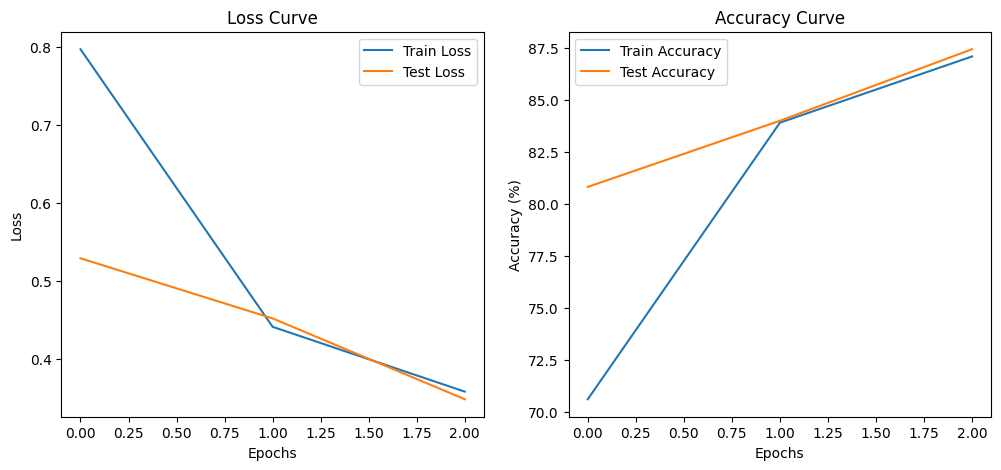

Training and testing on CIFAR10 dataset:
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/3, Train Loss: 1.7037, Train Acc: 35.96%, Test Loss: 1.4105, Test Acc: 48.05%
Epoch 2/3, Train Loss: 1.2855, Train Acc: 53.15%, Test Loss: 1.1853, Test Acc: 57.18%
Epoch 3/3, Train Loss: 1.0762, Train Acc: 61.51%, Test Loss: 1.0228, Test Acc: 63.59%
Training Complete
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.62      0.66      1000
           1       0.84      0.72      0.78      1000
           2       0.49      0.52      0.50      1000
           3       0.56      0.34      0.42      1000
           4       0.55      0.57      0.56      1000
           5       0.53      0.59      0.56      1000
           6       0.75      0.65      0.70      1000
           7       0.63      0.73      0.68      1000
           8       0.82      0.70      0.76      1000
           9       0.59      0.90      0.71

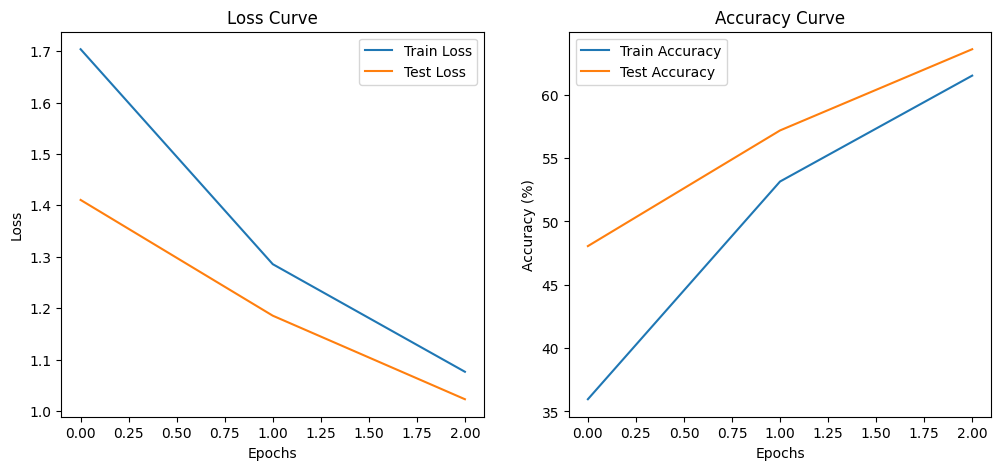

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# 1. Preprocessing and Data Loading
def load_data(dataset_name, batch_size=64):
    transform = transforms.Compose([
        transforms.Resize((64, 64)),  # Reduce input size to speed up computation
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  # Normalization
    ])

    if dataset_name == "MNIST":
        train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
        test_dataset = datasets.MNIST(root="./data", train=False, transform=transform, download=True)
    elif dataset_name == "FMNIST":
        train_dataset = datasets.FashionMNIST(root="./data", train=True, transform=transform, download=True)
        test_dataset = datasets.FashionMNIST(root="./data", train=False, transform=transform, download=True)
    elif dataset_name == "CIFAR10":
        transform = transforms.Compose([
            transforms.Resize((64, 64)),  # Reduce input size
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        train_dataset = datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)
        test_dataset = datasets.CIFAR10(root="./data", train=False, transform=transform, download=True)
    else:
        raise ValueError("Unsupported dataset")

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader


# 2. Define Xception Architecture
class Xception(nn.Module):
    def __init__(self, in_channels=3, num_classes=10):
        super(Xception, self).__init__()
        self.entry_flow = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.middle_flow = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.exit_flow = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.entry_flow(x)
        x = self.middle_flow(x)
        x = self.exit_flow(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


# 3. Training Function
def train_model(model, train_loader, test_loader, epochs=5, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_loss_history = []
    train_acc_history = []
    test_loss_history = []
    test_acc_history = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)

        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        test_loss /= len(test_loader)
        test_acc = 100. * correct / total
        test_loss_history.append(test_loss)
        test_acc_history.append(test_acc)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

    print("Training Complete")

    # Evaluation Metrics
    print("Classification Report:")
    print(classification_report(all_labels, all_preds))

    print("Confusion Matrix:")
    print(confusion_matrix(all_labels, all_preds))

    # Plot Loss and Accuracy
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_loss_history, label="Train Loss")
    plt.plot(test_loss_history, label="Test Loss")
    plt.title("Loss Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_acc_history, label="Train Accuracy")
    plt.plot(test_acc_history, label="Test Accuracy")
    plt.title("Accuracy Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend()

    plt.show()


# 4. Main Execution
def main():
    datasets_to_test = ["MNIST", "FMNIST", "CIFAR10"]
    for dataset_name in datasets_to_test:
        print(f"Training and testing on {dataset_name} dataset:")
        train_loader, test_loader = load_data(dataset_name, batch_size=128)
        model = Xception(in_channels=1 if dataset_name in ["MNIST", "FMNIST"] else 3, num_classes=10)
        train_model(model, train_loader, test_loader, epochs=3, lr=0.001)


if __name__ == "__main__":
    main()


SENet

Training and testing on MNIST dataset:
Epoch 1/5, Train Loss: 0.8245, Train Acc: 71.64%, Test Loss: 0.2016, Test Acc: 93.85%
Epoch 2/5, Train Loss: 0.1744, Train Acc: 94.62%, Test Loss: 0.1038, Test Acc: 96.87%
Epoch 3/5, Train Loss: 0.1084, Train Acc: 96.65%, Test Loss: 0.0846, Test Acc: 97.43%
Epoch 4/5, Train Loss: 0.0799, Train Acc: 97.55%, Test Loss: 0.0573, Test Acc: 98.02%
Epoch 5/5, Train Loss: 0.0607, Train Acc: 98.11%, Test Loss: 0.0570, Test Acc: 97.90%
Training Complete
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       980
           1       0.98      1.00      0.99      1135
           2       0.99      0.97      0.98      1032
           3       0.97      0.99      0.98      1010
           4       0.99      0.98      0.99       982
           5       0.99      0.97      0.98       892
           6       0.97      0.99      0.98       958
           7       0.99      0.98      0.99      1028
   

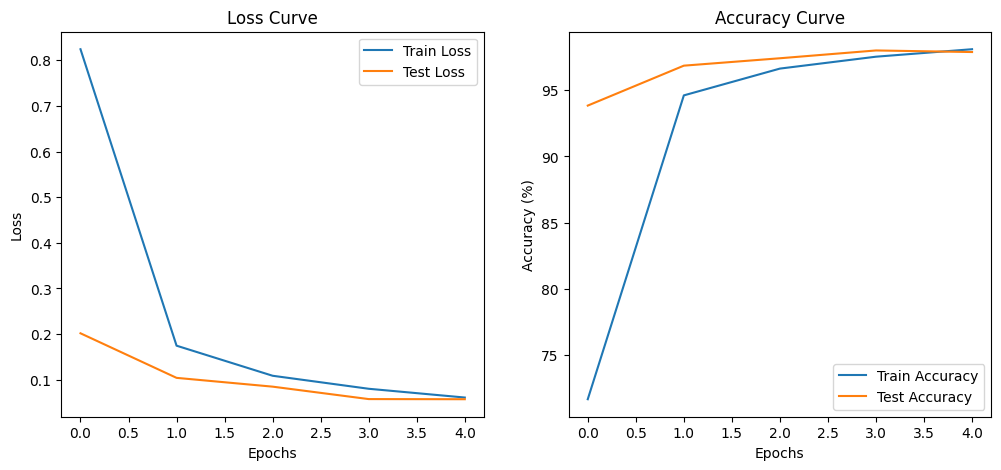

Training and testing on FMNIST dataset:
Epoch 1/5, Train Loss: 0.8628, Train Acc: 67.88%, Test Loss: 0.6020, Test Acc: 77.20%
Epoch 2/5, Train Loss: 0.4766, Train Acc: 82.65%, Test Loss: 0.4654, Test Acc: 82.86%
Epoch 3/5, Train Loss: 0.3819, Train Acc: 86.09%, Test Loss: 0.3620, Test Acc: 87.24%
Epoch 4/5, Train Loss: 0.3257, Train Acc: 88.19%, Test Loss: 0.3532, Test Acc: 86.89%
Epoch 5/5, Train Loss: 0.2966, Train Acc: 89.13%, Test Loss: 0.2932, Test Acc: 89.13%
Training Complete
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.88      0.84      1000
           1       1.00      0.96      0.98      1000
           2       0.89      0.79      0.84      1000
           3       0.87      0.90      0.88      1000
           4       0.82      0.82      0.82      1000
           5       0.99      0.97      0.98      1000
           6       0.69      0.71      0.70      1000
           7       0.93      0.96      0.95      1000
  

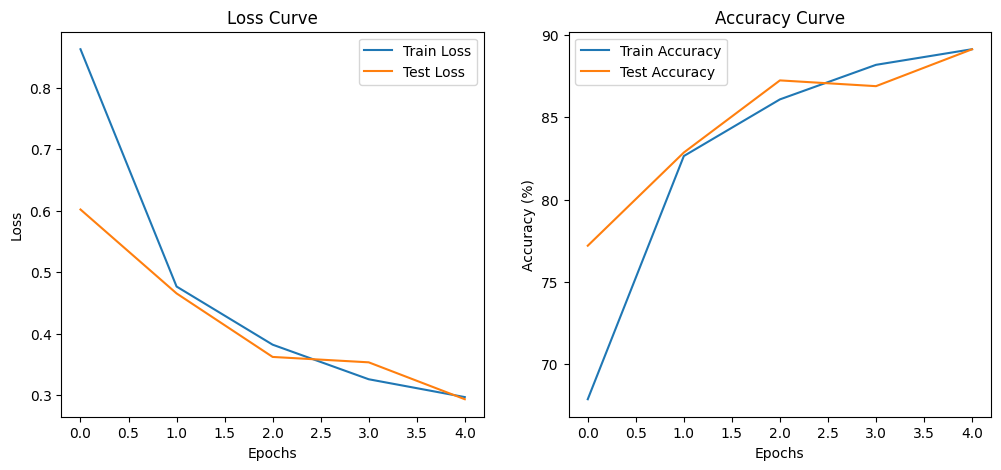

Training and testing on CIFAR10 dataset:
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/5, Train Loss: 1.8177, Train Acc: 31.83%, Test Loss: 1.5746, Test Acc: 40.50%
Epoch 2/5, Train Loss: 1.4696, Train Acc: 46.19%, Test Loss: 1.3527, Test Acc: 50.30%
Epoch 3/5, Train Loss: 1.2785, Train Acc: 53.74%, Test Loss: 1.1973, Test Acc: 56.04%
Epoch 4/5, Train Loss: 1.1170, Train Acc: 60.24%, Test Loss: 1.1031, Test Acc: 60.73%
Epoch 5/5, Train Loss: 1.0020, Train Acc: 64.73%, Test Loss: 0.9555, Test Acc: 65.83%
Training Complete
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.59      0.67      1000
           1       0.84      0.75      0.79      1000
           2       0.43      0.67      0.52      1000
           3       0.46      0.45      0.46      1000
           4       0.68      0.51      0.58      1000
           5       0.62      0.55      0.58      1000
           6       0.75      0.72

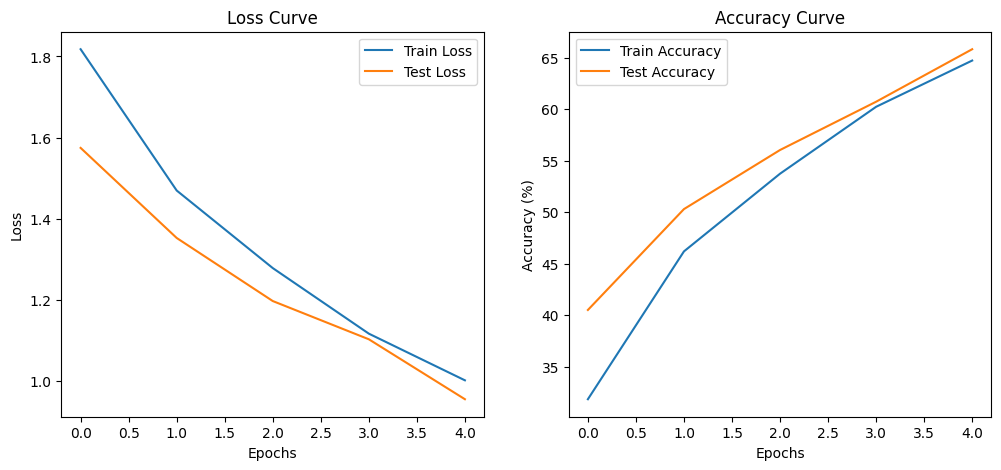

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# 1. Preprocessing and Data Loading
def load_data(dataset_name, batch_size=64):
    transform = transforms.Compose([
        transforms.Resize((64, 64)),  # Reduce input size to speed up computation
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  # Normalization
    ])

    if dataset_name == "MNIST":
        train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
        test_dataset = datasets.MNIST(root="./data", train=False, transform=transform, download=True)
    elif dataset_name == "FMNIST":
        train_dataset = datasets.FashionMNIST(root="./data", train=True, transform=transform, download=True)
        test_dataset = datasets.FashionMNIST(root="./data", train=False, transform=transform, download=True)
    elif dataset_name == "CIFAR10":
        transform = transforms.Compose([
            transforms.Resize((64, 64)),  # Reduce input size
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        train_dataset = datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)
        test_dataset = datasets.CIFAR10(root="./data", train=False, transform=transform, download=True)
    else:
        raise ValueError("Unsupported dataset")

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader


# 2. Define SENet Architecture
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.global_avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y


class SENet(nn.Module):
    def __init__(self, in_channels=3, num_classes=10):
        super(SENet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            SEBlock(64),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            SEBlock(128),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            SEBlock(256),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            SEBlock(512),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


# 3. Training Function
def train_model(model, train_loader, test_loader, epochs=5, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_loss_history = []
    train_acc_history = []
    test_loss_history = []
    test_acc_history = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)

        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        test_loss /= len(test_loader)
        test_acc = 100. * correct / total
        test_loss_history.append(test_loss)
        test_acc_history.append(test_acc)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

    print("Training Complete")

    # Evaluation Metrics
    print("Classification Report:")
    print(classification_report(all_labels, all_preds))

    print("Confusion Matrix:")
    print(confusion_matrix(all_labels, all_preds))

    # Plot Loss and Accuracy
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_loss_history, label="Train Loss")
    plt.plot(test_loss_history, label="Test Loss")
    plt.title("Loss Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_acc_history, label="Train Accuracy")
    plt.plot(test_acc_history, label="Test Accuracy")
    plt.title("Accuracy Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend()

    plt.show()


# 4. Main Execution
def main():
    datasets_to_test = ["MNIST", "FMNIST", "CIFAR10"]
    for dataset_name in datasets_to_test:
        print(f"Training and testing on {dataset_name} dataset:")
        train_loader, test_loader = load_data(dataset_name, batch_size=128)
        model = SENet(in_channels=1 if dataset_name in ["MNIST", "FMNIST"] else 3, num_classes=10)
        train_model(model, train_loader, test_loader, epochs=5, lr=0.001)


if __name__ == "__main__":
    main()
